## Estimating Average Treatment Effect (ATE)

When dealing with causal inference, most of the time we will have available observational data for a given study, and then we want to estimate the causal effect of a given treatment. For simplification, let's assume the following notation:

* $T$ is our **treatment variable** - which, in this case, is binary (0: untreated; 1: treated);
* $Y_{0}, Y_{1}$ are the so-called **potential outcomes**. This name originates from the fact that we can actually observe one of them in reality, which leads to the well-known Fundamental Problem of Causal Inference. For a treated individual, $Y_{1}$ is the outcome we observe, whereas $Y_{0}$ is the one we would have observed, had the individual not received treatment. On the other hand, for an untreated individual, $Y_{0}$ is the outcome we observe, whereas $Y_{1}$ is the one we would have observed, had the individual received treatment.

Mathematically speaking, we want to estimate ATE as follows:

$ATE = \mathbb{E}[Y_{1} - Y_{0}]$

For people with industry experience and familiarity with A/B testing, it is very tempting to simplify this equation and compute the difference in means:

$\mathbb{E}[Y| T = 1] - \mathbb{E}[Y| T = 0]$

This is very often misleading, since its validity depends on whether there is bias or not. One of the reasons why people tend to use this straightforward computation is the fact that A/B tests usually imply what is called as the gold-standard of experimentation: **Randomized Controlled Trials (RCTs)**. In such setting, both groups - treated and untreated - are **completely randomized** from the whole population. Hence, we are able to (almost) eliminate bias.

When this is not the case, we are mainly subjected to bias. This is where **confounders** come into play: there are some variables other than our treatment that might affect both the treatment and the outcome. A silly example is when we are trying to estimate the causal effect of education on wages - probably, some other factors such as income affect both. Rich people can afford high education and earn more, whereas poor people won't likely go to college and will have lower salaries due to their background. Hence, we need to control for $X$ - our confounders.

In a nutshell, there are two main types of bias:

* **Omitted Variables Bias (OVB)** - when there are unknown or unobservable confounders ($U$);
* **Confounding Bias** - when we are not accounting for known and observable confounders ($X$).

Let's understand our bias mathematically:

$\mathbb{E}[Y| T = 1] - \mathbb{E}[Y| T = 0] = \mathbb{E}[Y_{1}| T = 1] - \mathbb{E}[Y_{0}| T = 0]$

Let's add and subtract $\mathbb{E}[Y_{0}| T = 1]$:


$\mathbb{E}[Y| T = 1] - \mathbb{E}[Y| T = 0] = \mathbb{E}[Y_{1}| T = 1] - \mathbb{E}[Y_{0}| T = 0] + \mathbb{E}[Y_{0}| T = 1] - \mathbb{E}[Y_{0}| T = 1]$

Hence:

$\mathbb{E}[Y| T = 1] - \mathbb{E}[Y| T = 0] = (\mathbb{E}[Y_{1} - Y_{0}| T = 1]) + (\mathbb{E}[Y_{0}| T = 1] - \mathbb{E}[Y_{0}| T = 0])$

The first term is the **Average Treatment Effect on the Treated (ATET)**, while the second one is the **BIAS**. Intuitively, we can see that it is simply defined as the baseline level (no treatment) for both populations. If they have some differences when not treated, then we need to account for it.

So, the more generalized version of ATE is the one where we **control for confounders**:

$ATE = \mathbb{E}[Y_{1} - Y_{0}]$, provided that $Y_{0}, Y_{1} \perp T|X$

A simple way to do that is relying on **Linear Regression**. Given its properties of covariate independence, we are able to estimate the treatment effect while controlling for confounders by simply adding both of them to the model.

This is what we are going to do here.

### Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import statsmodels.formula.api as smf

from causalinference import CausalModel

### Data

For the sake of simplicity and learning, we are going to use a well-know dataset for causal effects estimation: **Lalonde**. This is a famous dataset to estimate the impact of a training program (National Supported Work Demonstration) on the income of beneficiaries in 1978.

Basically, we have demographic data on individuals and whether or not they engaged in a training programme (aka treatment). Our task is to estimate the treatment effect of this training on future wages.

In [2]:
df = pd.read_csv("../data/lalonde.csv", index_col=[0])
df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
5,1,33,8,1,0,0,1,0.0,0.0,289.7899


Some basic definitions:

In [3]:
Y = "re78"
T = "treat"
X = [c for c in df.columns if not c in [Y, T]]

### Biased Estimation

As mentioned above, let's simply compute a difference of averages, which is very likely biased, once other factors, such as ethnicity, previous wages and education, could highly impact the final outcome.

In [4]:
biased_ate = df.query(f"{T} == 1")[Y].mean() - df.query(f"{T} == 0")[Y].mean()
print(f"{biased_ate:.2f}")

-635.03


So, our estimate tells us that taking part in the training program actually decreases salary by $635.03. This sounds a little counterintuitive, right?

Additionally, we cannot ever rely on point estimates!!! Let's add some confidence intervals.

In [5]:
s1 = df.query(f"{T} == 1")[Y].std()
s2 = df.query(f"{T} == 0")[Y].std()

n1 = len(df.query(f"{T} == 1"))
n2 = len(df.query(f"{T} == 0"))

dof = n1 + n2 - 2

s = np.sqrt(
    ((n1 - 1)*(s1**2) + (n2 - 1)*(s2**2)) / dof
)
t = ss.t.ppf(q=0.975, df=dof)
se = t * s * np.sqrt(1/n1 + 1/n2)

In [6]:
lower_ci = biased_ate - se
upper_ci = biased_ate + se
print(f"CI: ({lower_ci:.2f}, {upper_ci:.2f})")


CI: (-1925.54, 655.49)


Now that we have a confidence interval, we can even conclude that the estimated treatment effect is not statistically significant.

### ATE: Linear Regression

As mentioned previously, let's use linear regression to automatically generate our ate while controlling for confounders.

One of the main benefits of linear regression with `statsmodels` package is that it **automatically generates the confidence intervals** for us.

In [7]:
model = smf.ols(formula=f"{Y} ~ {T} + {'+'.join(X)}", data=df).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,66.5145,2436.746,0.027,0.978,-4719.009,4852.038
treat,1548.2438,781.279,1.982,0.048,13.890,3082.598
age,12.9776,32.489,0.399,0.690,-50.827,76.783
educ,403.9412,158.906,2.542,0.011,91.865,716.017
black,-1240.6441,768.764,-1.614,0.107,-2750.420,269.132
hispan,498.8969,941.943,0.530,0.597,-1350.983,2348.777
married,406.6208,695.472,0.585,0.559,-959.217,1772.458
nodegree,259.8174,847.442,0.307,0.759,-1404.474,1924.108
re74,0.2964,0.058,5.086,0.000,0.182,0.411
re75,0.2315,0.105,2.213,0.027,0.026,0.437


In [8]:
ate = model.params[T]
lower_ci, upper_ci = model.conf_int().loc[T].values
p_value = model.pvalues[T]
print(f"Estimate ATE = {ate:.2f}")
print(f"CI: ({lower_ci:.2f}, {upper_ci:.2f})")
print(f"p-value: {p_value:.4f}")

Estimate ATE = 1548.24
CI: (13.89, 3082.60)
p-value: 0.0480


Now we've got an estimate of ATE that resonates with our prior causal model - or at least with the way we think the world operates. We see that it is very close to not being statiscally significant, but the training results in higher income, with an average of $1,550.

### Covariance Independence

One important feature of linear regression is that we can estimate such coefficients from residual regression. Basically, we follow these steps:

(1) Build regression of Y on X (not including T);  
(2) Compute residuals $\widetilde{Y} = Y - \hat{Y}$;  
(3) Build regression of T on X (not inxluding Y);
(4) Compute residuals $\widetilde{T} = T - \hat{T}$;  
(5) Build regression of $\widetilde{Y}$ on $\widetilde{T}$

In [9]:
y_on_x = smf.ols(formula=f"{Y} ~ {' + '.join(X)}", data=df).fit()
t_on_x = smf.ols(formula=f"{T} ~ {' + '.join(X)}", data=df).fit()

df_ = df.assign(**{
    "y_res": y_on_x.resid, "t_res": t_on_x.resid
})

res_model = smf.ols(formula=f"y_res ~ t_res", data=df_).fit()
res_model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-1.836e-10,278.556,-6.59e-13,1.000,-547.042,547.042
t_res,1548.2438,776.156,1.995,0.047,23.991,3072.496


### Python package: `causalinference`

Let's take a look at how we can accomplish the same task by using a thirdy party library.

In [10]:
model = CausalModel(
    Y=df[Y].values.squeeze(),
    D=df[T].values.squeeze(),
    X=df[X].values,
)
model.est_via_ols(adj=1)
model.estimates

/Users/gfluz94/.causal-inference/lib/python3.9/site-packages/causalinference/estimators/ols.py:21: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  olscoef = np.linalg.lstsq(Z, Y)[0]


{'ols': {'ate': 1548.2438019995625, 'ate_se': 734.5205423582663}}

### Our approach

In [11]:
from causal_inference.linear import OLSEstimator

In [12]:
m = OLSEstimator(data=df, outcome=Y, treatment=T, covariates=X, heterogeneous=False)
m.fit()

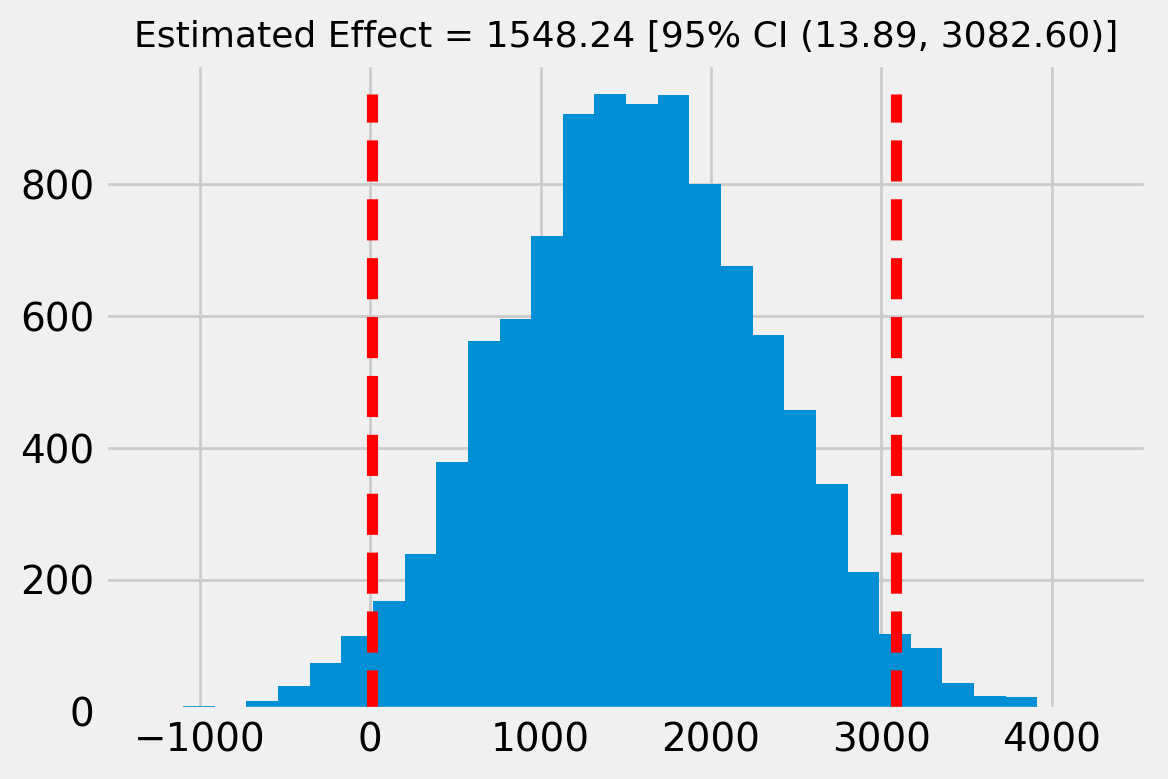

{'ATE': 1548.243802000623,
 'SE': 781.2792974603111,
 'CI': (13.889909816829004, 3082.597694184417),
 'p-VALUE': 0.04796824155360068}

In [13]:
m.estimate_ate(plot_result=True)

For **Conditional Average Treatment Effect (CATE)** - where we take heterogeneity into account - we have also a method implemented. It is just important to remember to set the flag `heterogeneous=True`.

Since we're estimating the CATE for each individual, it is not straightforward to come up with confidence intervals. Hence, we rely on **bootstrapping**.

In [14]:
m = OLSEstimator(data=df, outcome=Y, treatment=T, covariates=X, heterogeneous=True)
m.fit()

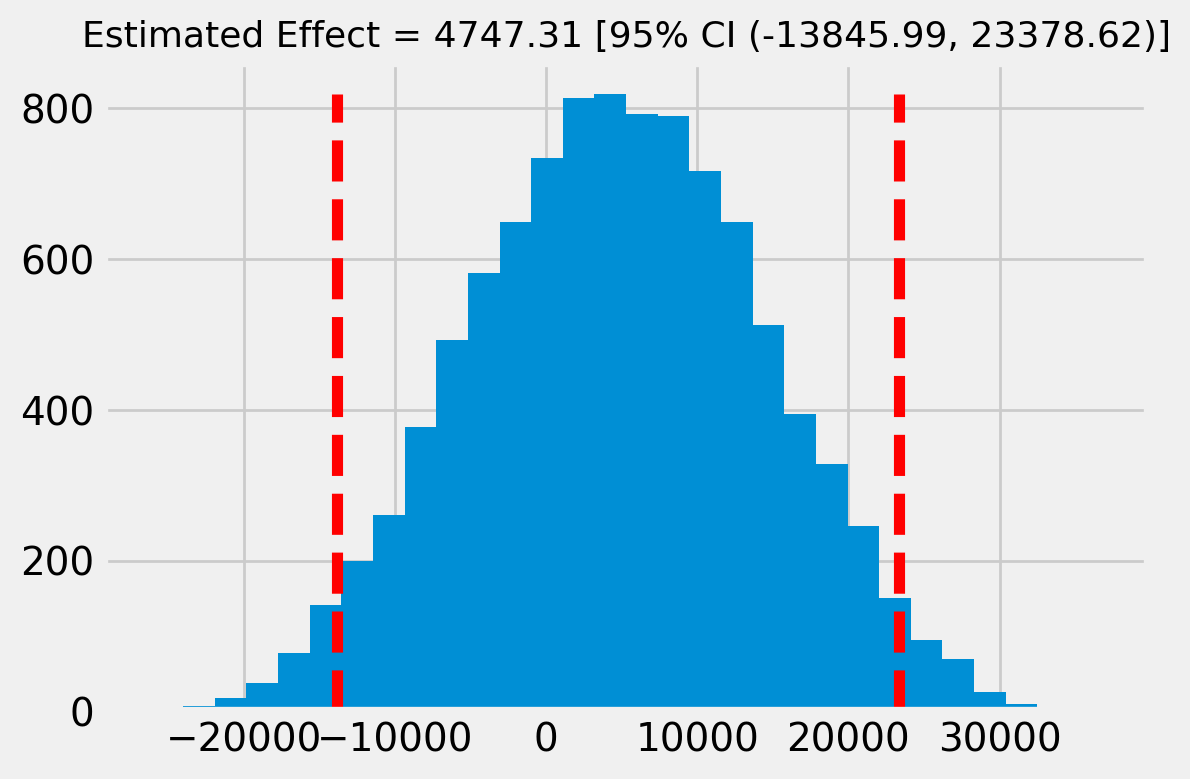

{'CATE': 4747.307902161482, 'CI': (-13845.990407823801, 23378.62083018334)}

In [15]:
m.estimate_cate(covariates=df.iloc[0, 1:-1].to_dict(), plot_result=True)